In [14]:
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings

embedding_function = UpstageEmbeddings(
    model="embedding-query"
)

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(
    search_kwargs={"k": 3}
)

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState):
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-5-mini"
)

In [5]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({"question": query, "context": context})
    return {"answer": response}

c:\Users\wjdtp\miniconda3\envs\langchain-basic\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from typing import Literal
from langchain import hub


doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state["query"]
    context = state["context"]
    print(f'context: {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    print(f'doc_relevance_response: {response}')
    if response['Score'] == 1:
        return 'generate'
        
    return 'rewrite'

c:\Users\wjdtp\miniconda3\envs\langchain-basic\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
query = '연봉 5천만원 직장인의 소득세는?'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 => 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, dictionary를 참고해서 사용자의 질문을 변경해주세요
dictionary: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [9]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [10]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [11]:
graph = graph_builder.compile()


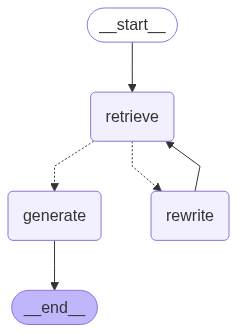

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context: [Document(id='4fdab589-9565-46d9-b192-66ae65595073', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원\n2명인 경우: 연 35만원\n3명 이상인 경우

{'query': '연봉 5천만원 세금',
 'context': [Document(id='4fdab589-9565-46d9-b192-66ae65595073', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원